# 🍇 Full YOLOv8 Fine-Tuning Notebook

## 🟨 Install YOLOv8

In [1]:
!pip install ultralytics --upgrade -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00


## 🟨 Upload and Extract ZIP Dataset

In [2]:
from google.colab import files
import zipfile
import os

# Upload ZIP
uploaded = files.upload()

# Extract ZIP
zip_file = next(iter(uploaded))
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# Detect extracted folder name
extracted_folder = zip_file.replace('.zip', '')
print(f"Extracted dataset to: {extracted_folder}")

Saving Fruits_Dataset.zip to Fruits_Dataset.zip
Extracted dataset to: Fruits_Dataset


## 🟨 Verify Dataset Structure

In [3]:
base_dir = '/content/Fruits_Dataset'

for split in ['train', 'valid', 'test']:
    image_dir = os.path.join(base_dir, split, 'images')
    label_dir = os.path.join(base_dir, split, 'labels')
    print(f"\n{split.upper()} SET")
    print(f"Images: {len(os.listdir(image_dir))}")
    print(f"Labels: {len(os.listdir(label_dir))}")


TRAIN SET
Images: 2424
Labels: 2424

VALID SET
Images: 303
Labels: 303

TEST SET
Images: 303
Labels: 303


## 🟨 Set Class Names and Create YAML

In [4]:
class_names = ['apple', 'banana', 'dragon fruit', 'guava', 'oren', 'pear', 'pineapple', 'sugar apple']

yaml_text = f"""
path: {base_dir}
train: train/images
val: valid/images
test: test/images
nc: {len(class_names)}
names: {class_names}
"""

with open("fruits.yaml", "w") as f:
    f.write(yaml_text)

print("Created fruits.yaml ✅")

Created fruits.yaml ✅


## 🟨 Visualize Annotated Random Images (Before Training)

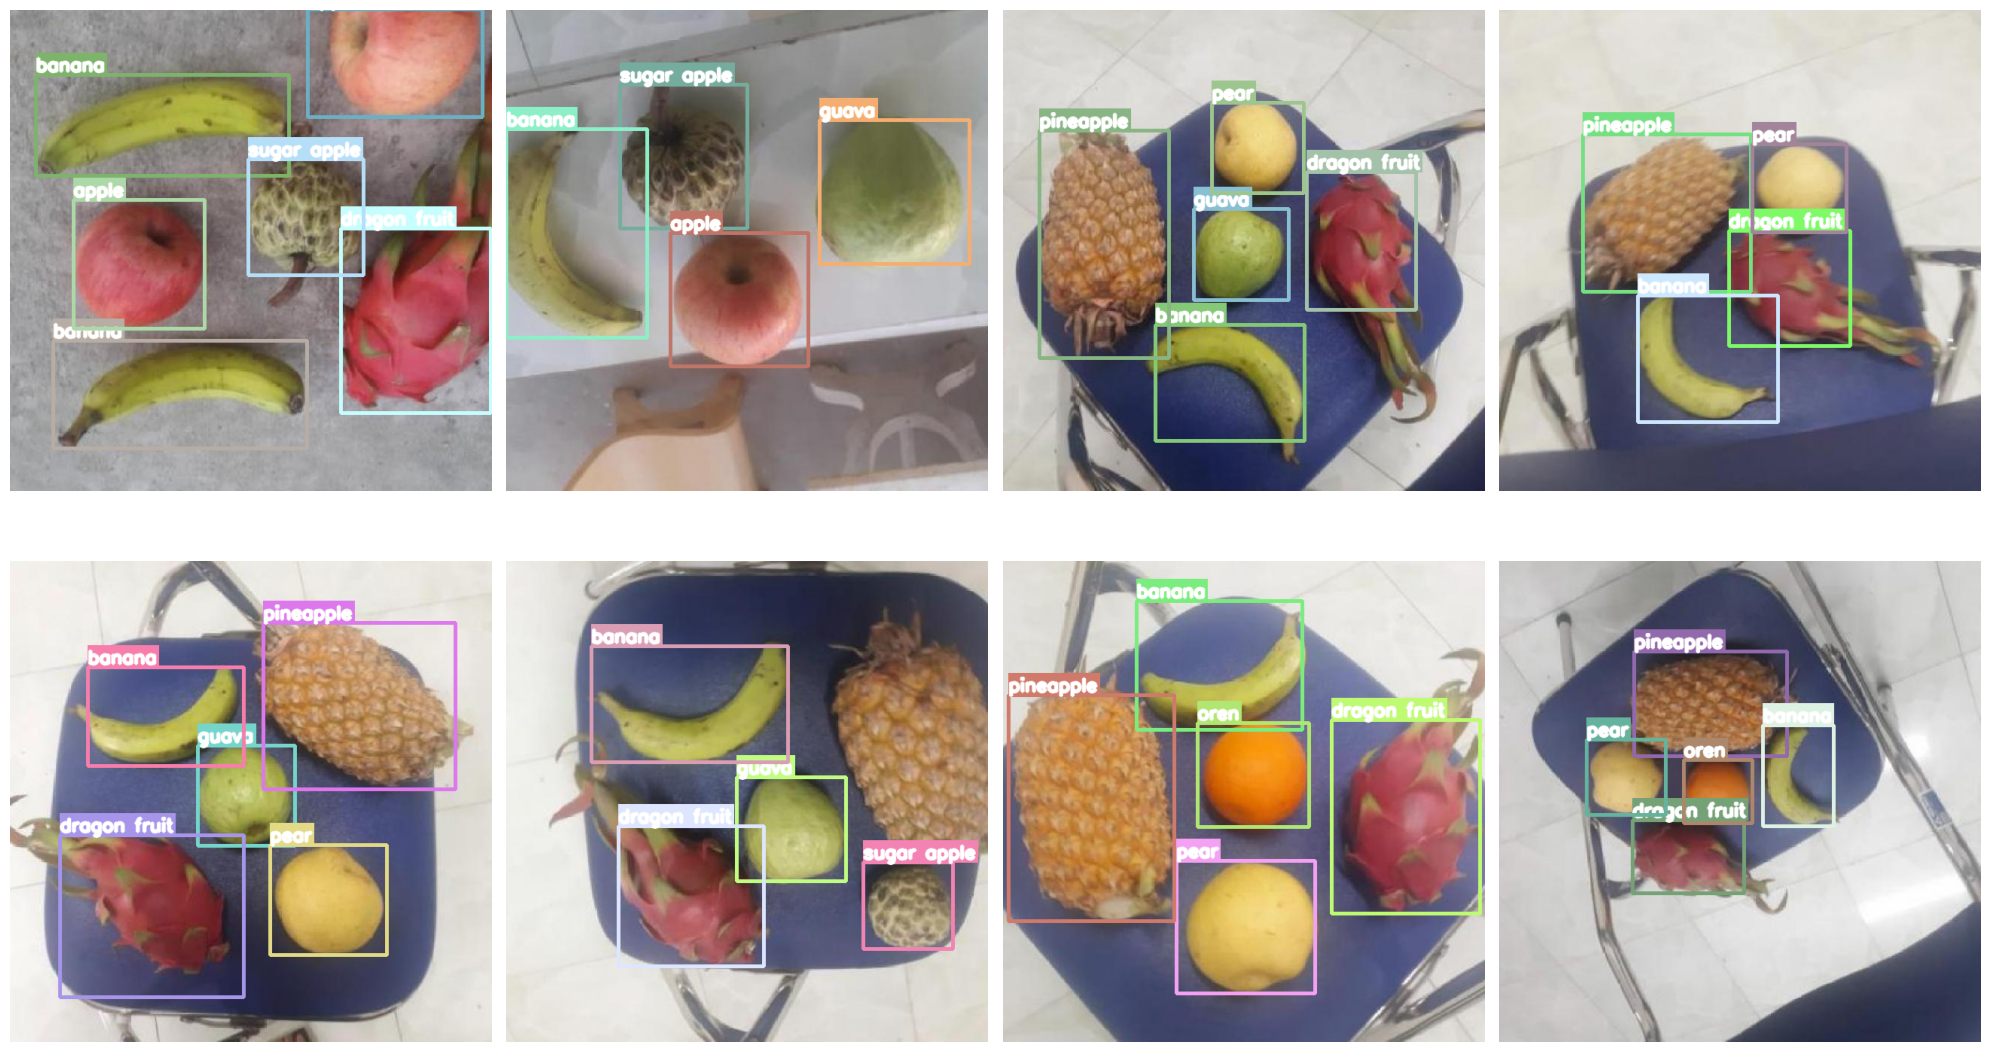

In [5]:
import cv2
import matplotlib.pyplot as plt
import random
import os

def draw_boxes(image_path, label_path, class_names):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(label_path, 'r') as f:
        for line in f:
            cls_id, cx, cy, bw, bh = map(float, line.strip().split())
            cls_id = int(cls_id)
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            color = tuple([random.randint(100, 255) for _ in range(3)])

            # Draw bold rectangle (thicker)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=4)

            label = class_names[cls_id]
            font_scale = 0.8
            font = cv2.FONT_HERSHEY_SIMPLEX
            thickness = 3

            # Get text size
            (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, thickness)
            # Optional: draw filled box behind text
            cv2.rectangle(img, (x1, y1 - text_height - 10), (x1 + text_width, y1), color, -1)
            # Put bold text (white over colored background)
            cv2.putText(img, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness, lineType=cv2.LINE_AA)
    return img

# Show 8 random images from train set
image_dir = os.path.join(base_dir, "train", "images")
label_dir = os.path.join(base_dir, "train", "labels")
sample_files = random.sample(os.listdir(image_dir), 8)

plt.figure(figsize=(20, 12))
for idx, fname in enumerate(sample_files):
    img_path = os.path.join(image_dir, fname)
    lbl_path = os.path.join(label_dir, fname.replace(".jpg", ".txt").replace(".png", ".txt"))
    image = draw_boxes(img_path, lbl_path, class_names)
    plt.subplot(2, 4, idx + 1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 🟨 Train YOLOv8

In [6]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

model.train(
    data="fruits.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    name="fruits_yolov8"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 21.5M/21.5M [00:01<00:00, 15.1MB/s]


Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=fruits.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fruits_yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

100%|██████████| 755k/755k [00:00<00:00, 21.8MB/s]

Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2119144  ultralytics.nn.modules.head.Detect           [8, [128, 256, 512]]          
Model summary: 129 layers, 11,138,696 parameters, 11,138,680 gradients, 28.7 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 99.1MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 733.5±239.9 MB/s, size: 29.1 KB)


train: Scanning /content/Fruits_Dataset/train/labels... 2424 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2424/2424 [00:01<00:00, 2083.17it/s]


train: New cache created: /content/Fruits_Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 642.9±322.9 MB/s, size: 29.1 KB)


val: Scanning /content/Fruits_Dataset/valid/labels... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<00:00, 1989.50it/s]

val: New cache created: /content/Fruits_Dataset/valid/labels.cache


Plotting labels to runs/detect/fruits_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/fruits_yolov8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.71G      0.857      1.267      1.154         67        640: 100%|██████████| 152/152 [00:48<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

                   all        303       1429      0.951      0.971      0.975      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       4.5G     0.7812     0.5927      1.101         53        640: 100%|██████████| 152/152 [00:45<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]

                   all        303       1429      0.902      0.954      0.951      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.54G     0.7796     0.5465        1.1         53        640: 100%|██████████| 152/152 [00:44<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        303       1429      0.958      0.959      0.975      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.58G      0.764     0.5269      1.098         84        640: 100%|██████████| 152/152 [00:44<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        303       1429      0.968      0.984      0.978      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.62G     0.7482      0.494      1.081         71        640: 100%|██████████| 152/152 [00:46<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]

                   all        303       1429      0.969      0.986      0.976      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.65G     0.7358     0.4759      1.079         91        640: 100%|██████████| 152/152 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        303       1429      0.968      0.986      0.976      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.69G     0.7146     0.4535      1.076         47        640: 100%|██████████| 152/152 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]

                   all        303       1429      0.973      0.984      0.982      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.72G     0.6977     0.4376      1.059         66        640: 100%|██████████| 152/152 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        303       1429      0.974      0.986      0.982      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.76G     0.6896     0.4214      1.059         56        640: 100%|██████████| 152/152 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

                   all        303       1429      0.968      0.982      0.982      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       4.8G     0.6727     0.4123      1.047         49        640: 100%|██████████| 152/152 [00:45<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]

                   all        303       1429      0.975      0.984      0.981      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.83G     0.6729     0.4045      1.044         56        640: 100%|██████████| 152/152 [00:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        303       1429      0.975      0.988      0.981      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.87G     0.6582     0.4043      1.039         54        640: 100%|██████████| 152/152 [00:46<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]

                   all        303       1429      0.973      0.987      0.983      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.91G      0.652     0.3936      1.042         91        640: 100%|██████████| 152/152 [00:45<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        303       1429      0.978      0.985      0.985      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.94G     0.6445     0.3781      1.036         51        640: 100%|██████████| 152/152 [00:45<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]

                   all        303       1429      0.976      0.987      0.986      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.98G     0.6345     0.3789      1.028         65        640: 100%|██████████| 152/152 [00:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


                   all        303       1429      0.975      0.986      0.985      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.02G     0.6306     0.3664      1.024         65        640: 100%|██████████| 152/152 [00:48<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


                   all        303       1429      0.977      0.987      0.987      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.05G     0.6129     0.3581      1.011         47        640: 100%|██████████| 152/152 [00:48<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

                   all        303       1429      0.972      0.989      0.984      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.09G     0.6058     0.3521      1.008         79        640: 100%|██████████| 152/152 [00:46<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


                   all        303       1429      0.978      0.988      0.985      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.12G     0.6029     0.3438      1.006         57        640: 100%|██████████| 152/152 [00:47<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]

                   all        303       1429      0.979      0.986      0.987      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.16G     0.5916     0.3366     0.9987         73        640: 100%|██████████| 152/152 [00:46<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        303       1429      0.976      0.987      0.987      0.885


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       5.2G     0.5227     0.2853     0.9575         36        640: 100%|██████████| 152/152 [00:46<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

                   all        303       1429      0.977      0.987      0.986      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.23G      0.509     0.2765     0.9524         38        640: 100%|██████████| 152/152 [00:44<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


                   all        303       1429      0.977      0.987      0.987      0.891

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.27G     0.4996     0.2651     0.9437         40        640: 100%|██████████| 152/152 [00:43<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

                   all        303       1429      0.977      0.988      0.987      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.31G     0.4921     0.2642     0.9427         40        640: 100%|██████████| 152/152 [00:44<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        303       1429      0.978      0.984      0.989      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.34G     0.4786     0.2521     0.9325         35        640: 100%|██████████| 152/152 [00:43<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]

                   all        303       1429       0.98      0.987      0.989      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.38G     0.4727     0.2472     0.9308         38        640: 100%|██████████| 152/152 [00:43<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        303       1429      0.979      0.985      0.987      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.42G     0.4636     0.2404     0.9245         38        640: 100%|██████████| 152/152 [00:45<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]

                   all        303       1429      0.978      0.987      0.987        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.45G     0.4563     0.2348     0.9236         38        640: 100%|██████████| 152/152 [00:44<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

                   all        303       1429      0.977      0.981      0.988      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.49G     0.4464     0.2291     0.9142         42        640: 100%|██████████| 152/152 [00:44<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

                   all        303       1429      0.978      0.986      0.988      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.52G     0.4399     0.2215     0.9093         42        640: 100%|██████████| 152/152 [00:44<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

                   all        303       1429       0.98      0.986      0.988      0.906



30 epochs completed in 0.412 hours.
Optimizer stripped from runs/detect/fruits_yolov8/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/fruits_yolov8/weights/best.pt, 22.5MB

Validating runs/detect/fruits_yolov8/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


                   all        303       1429       0.98      0.986      0.988      0.906
                 apple        149        201      0.991          1      0.993       0.92
                banana        263        412      0.994      0.985      0.994      0.887
          dragon fruit        165        166      0.994      0.996      0.993      0.871
                 guava        123        148      0.975      0.932      0.985      0.927
                  oren        100        100       0.98          1      0.976       0.92
                  pear         73         73      0.935       0.98      0.976      0.898
             pineapple        124        124      0.975          1      0.995      0.913
           sugar apple        205        205          1      0.996      0.995      0.915
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/fruits_yolov8


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78560f920c90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

## 🟨 Evaluate on Test Set

In [7]:
metrics = model.val(data="fruits.yaml", split="test")

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,128,680 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 845.8±300.2 MB/s, size: 33.8 KB)


val: Scanning /content/Fruits_Dataset/test/labels... 303 images, 0 backgrounds, 0 corrupt: 100%|██████████| 303/303 [00:00<00:00, 2384.50it/s]

val: New cache created: /content/Fruits_Dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.12it/s]


                   all        303       1429      0.982      0.988      0.992      0.913
                 apple        140        191      0.993      0.995      0.992      0.908
                banana        252        385      0.987      0.989      0.994      0.885
          dragon fruit        184        184      0.992          1      0.994      0.884
                 guava        119        137       0.98      0.956      0.988      0.925
                  oren        113        113      0.988          1      0.994      0.943
                  pear         93         94      0.953      0.979      0.985      0.921
             pineapple        135        135      0.971      0.989      0.994      0.924
           sugar apple        190        190       0.99      0.998      0.993      0.914
Speed: 1.3ms preprocess, 9.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/fruits_yolov82


## 🟨 Inference on Test Set (Visualize 10 Random Predictions)


0: 640x640 2 apples, 2 bananas, 1 dragon fruit, 1 sugar apple, 12.2ms
1: 640x640 1 apple, 2 bananas, 1 oren, 1 sugar apple, 12.2ms
2: 640x640 1 banana, 1 dragon fruit, 1 pear, 1 pineapple, 12.2ms
3: 640x640 1 banana, 1 dragon fruit, 1 pear, 1 pineapple, 12.2ms
4: 640x640 2 guavas, 1 pineapple, 12.2ms
5: 640x640 1 banana, 1 dragon fruit, 1 oren, 1 pear, 1 pineapple, 12.2ms
6: 640x640 2 guavas, 1 pineapple, 12.2ms
7: 640x640 1 banana, 1 dragon fruit, 1 pear, 1 pineapple, 12.2ms
8: 640x640 1 banana, 1 dragon fruit, 1 guava, 1 pineapple, 1 sugar apple, 12.2ms
9: 640x640 2 apples, 2 bananas, 1 dragon fruit, 1 sugar apple, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/fruits_yolov83
Predicted images saved to: runs/detect/fruits_yolov83


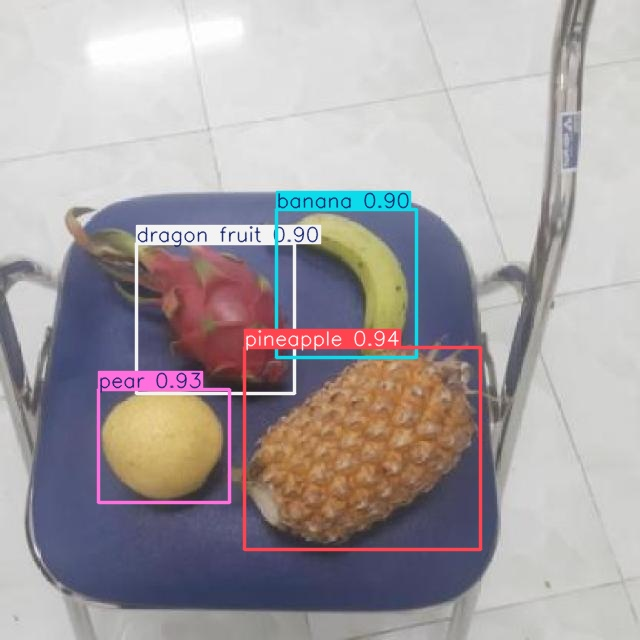

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


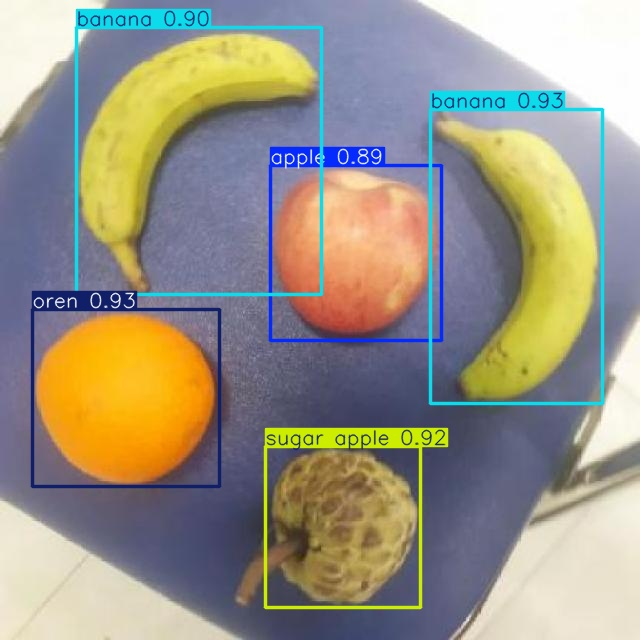

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


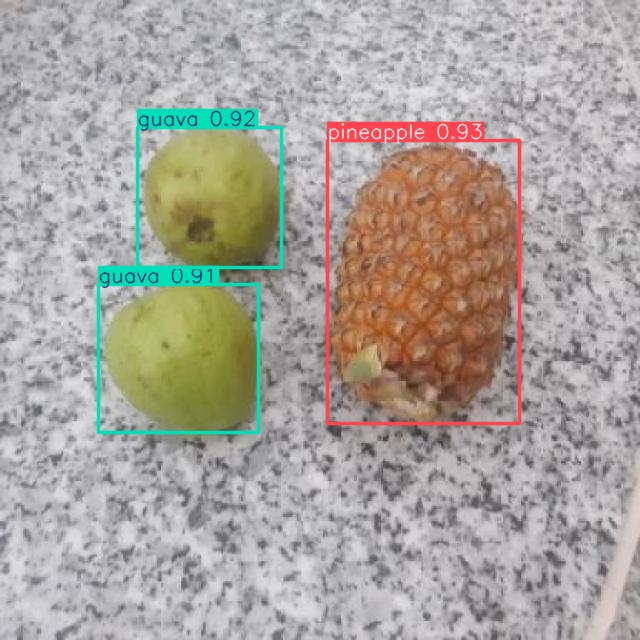

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


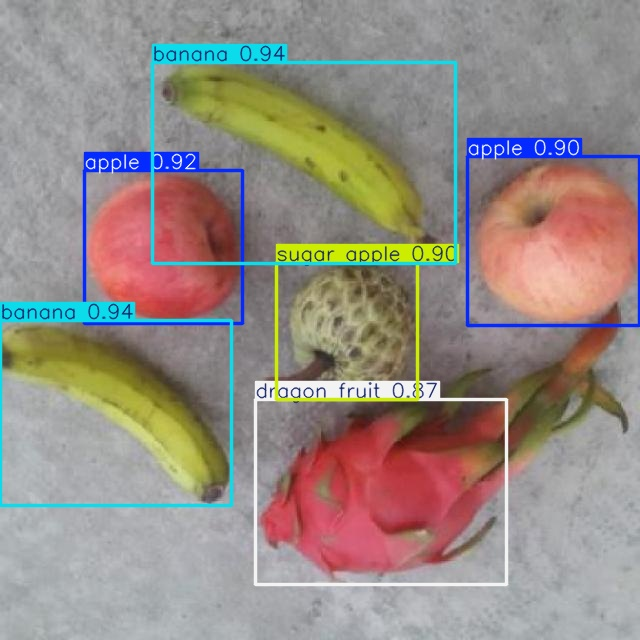

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


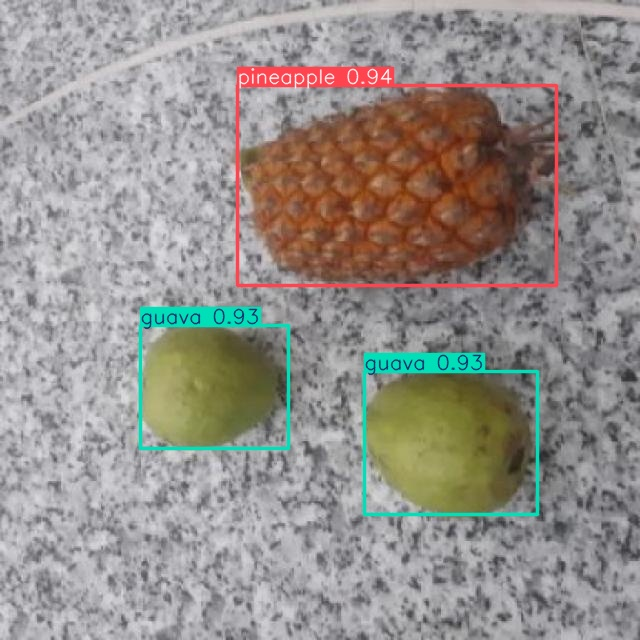

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


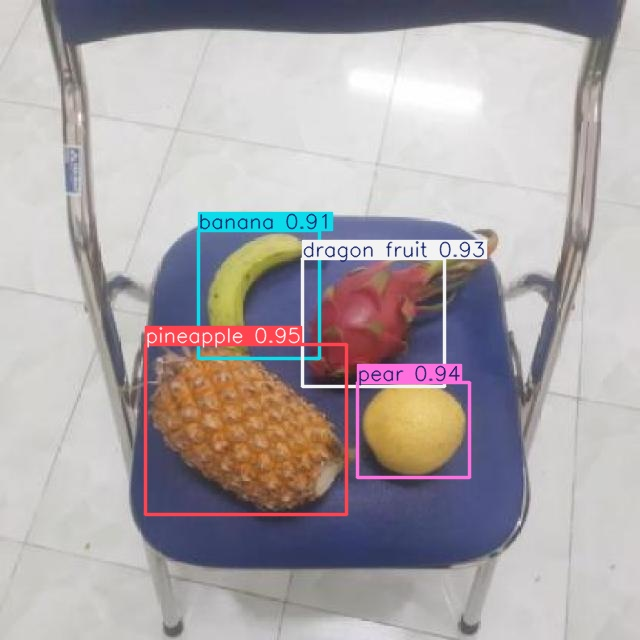

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


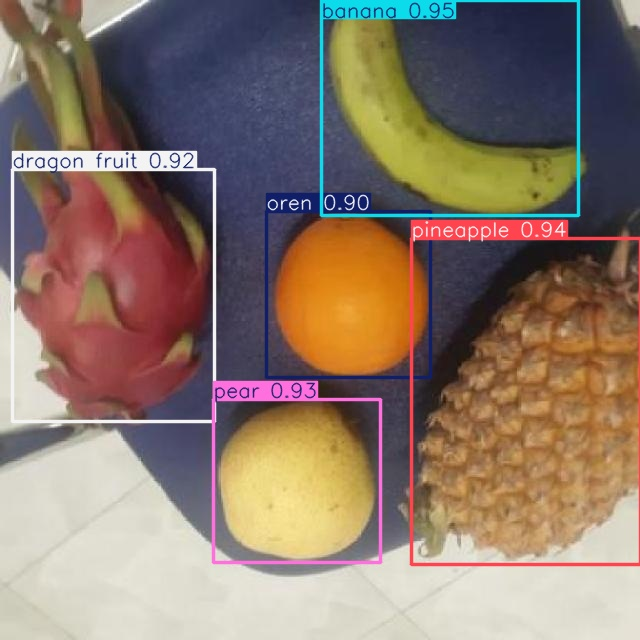

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


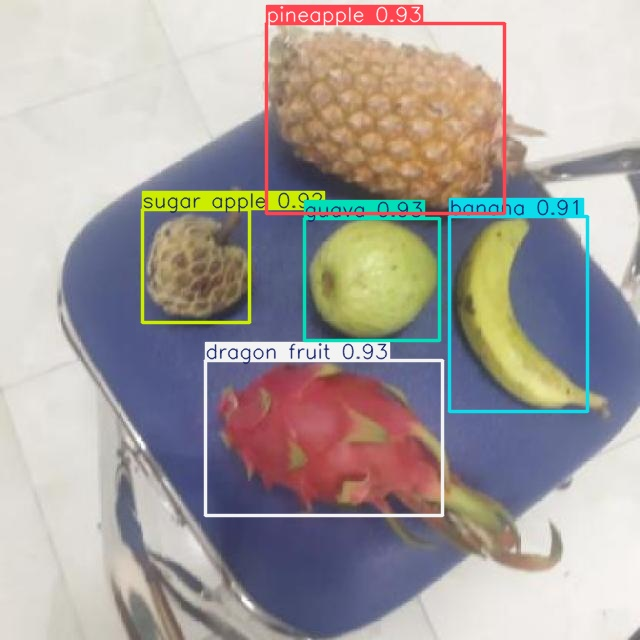

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


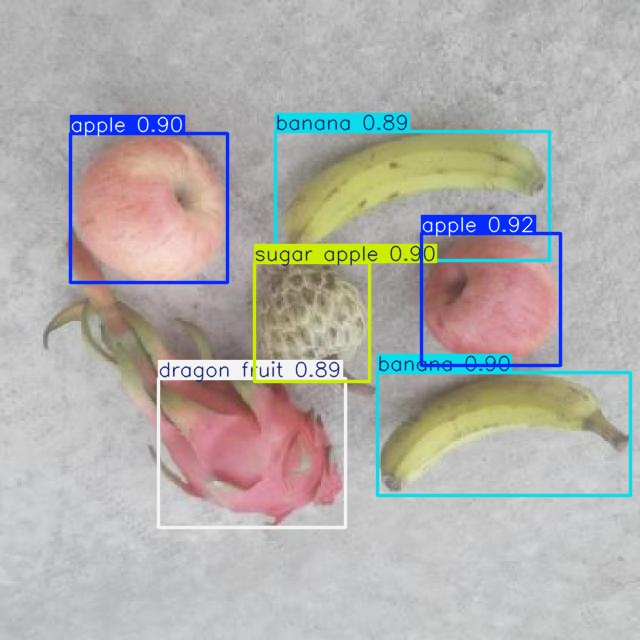

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


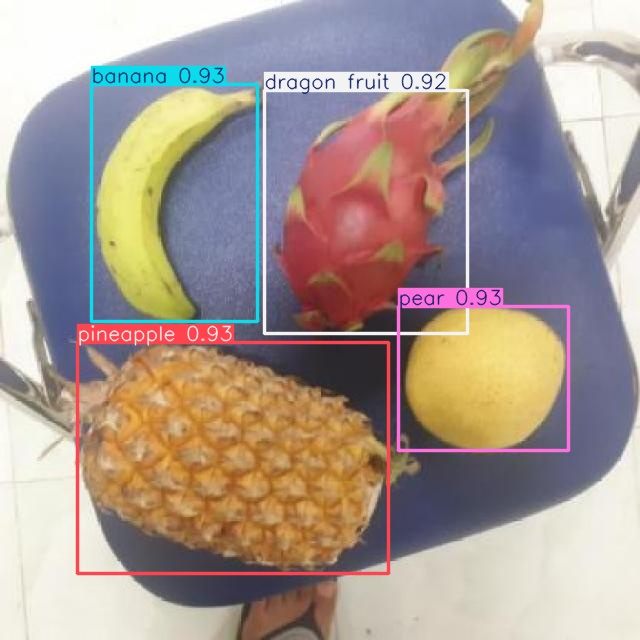

-----------------------------------------------------------------------------------
-----------------------------------------------------------------------------------


In [8]:
import glob
import random
from IPython.display import Image, display
import os

# Run prediction on test images
test_images = glob.glob(os.path.join(base_dir, "test/images/*.jpg"))
sample_images = random.sample(test_images, 10)

results = model.predict(source=sample_images, save=True, conf=0.25)

# Display results
pred_dir = results[0].save_dir
print(f"Predicted images saved to: {pred_dir}")

for img_name in os.listdir(pred_dir):
    if img_name.endswith(".jpg"):
        display(Image(filename=os.path.join(pred_dir, img_name)))
        print('-----------------------------------------------------------------------------------')
        print('-----------------------------------------------------------------------------------')

## 🟨 Export Model

In [9]:
model.export(format="onnx")

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/detect/fruits_yolov8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 12, 8400) (21.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 8.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.58...
ONNX: export success ✅ 10.8s, saved as 'runs/detect/fruits_yolov8/weights/best.onnx' (42.7 MB)

Export complete (11.8s)
Results saved to /content/runs/detect/fruits_yolov8/weights
Predict:         yolo predict task=detect model=runs/detect/fruits_yolov8/weights/best.onnx im

'runs/detect/fruits_yolov8/weights/best.onnx'